**Objectives:**
Setup an RIS system with the basic design to check its response
1. Transmit Power vs SNR
2. Transmit Power vs Channel Rate
3.Transmit Power vs Outage Probability
4. No. Of RIS elements vs SNR

In [163]:
import numpy as np

def watt_to_dbm(power_watt):
  """Converts power in watts to dBm.

  Args:
    power_watt: Power in watts.

  Returns:
    Power in dBm.
  """
  power_dbm = 10 * np.log10(power_watt * 1000)
  return power_dbm
watt_to_dbm(1)

30.0

Essentially What I need to do is:

Firstly, Identify the parameters for the simulation setup
Create functions for:

1. RICIAN Fading
2. Raleigh Fading
3. SNR Calculation
4. Total Outage Probability
5. RIS Setup
6. RIS Path Power Calculations
7. Direct Path Power Calculations(With variable for blockage probability)
8. Path Loss
9. Received Power Calculation

Additional Requirements:
1. Number of channel realisations
2. No. of RIS elements

For setting up:
Write module for running the intial required functions
Plot the powers of the RIS and Direct Path and Total Path Power
Then create the following plots:
1. Transmit Power vs SNR
2. Transmit Power vs Channel Rate
3. Transmit Power vs Outage Probability
4. No. Of RIS elements vs SNR

**Module 1: Simulation Setup — Channel Modeling**

1.   Direct Path (Rayleigh fading): semi-blocked.
2.   RIS Path (Rician fading): includes line-of-sight component.

We define functions for:

*   Distance-based path loss
*   Fading channel modeling
* Total channel gain





In [164]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt

# === Simulation Setup ===
np.random.seed(42)
num_realizations = 10000
num_RIS_elements = 50
Pt_dBm_values = np.arange(-45, 5, 5)  # Transmit Power in dBm
Pt_values = 10 ** ( (Pt_dBm_values - 30) / 10)  # Convert to Watts
wavelength = 0.1
n = 3  # Path loss exponent
block_prob = 0.8  # Probability that direct path is blocked
N_dBm = -96
N = 10 ** ( (N_dBm - 30) / 10) # Noise power in Watts
K_rician = 10  # Rician K-factor

# Positions
BS_pos = np.array([0, 0])
User_pos = np.array([100, 0])
RIS_pos = np.array([50, 30])


In [165]:

# === Core Functions ===

def path_loss(d):
    return (d**(-n))

def rayleigh_fading(size):
    return (np.random.normal(0, np.sqrt(0.5), size) +
                             1j * np.random.normal(0, np.sqrt(0.5), size))

def rician_fading(size, K=K_rician):
    LOS = np.ones(size)
    NLOS = np.sqrt(0.5) * (np.random.randn(size) + 1j * np.random.randn(size))
    return np.sqrt(K / (K + 1)) * LOS + np.sqrt(1 / (K + 1)) * NLOS

def snr_calc(Pr):
    return Pr / N

def outage_probability(rate, tau):
    return np.mean(rate < tau)

def received_power(Pt, h):
    return Pt * (h ** 2)

def random_ris_path_channel_coefficents(bs_pos, ris_pos, user_pos, N_elements):
    d_bs_ris = np.linalg.norm(bs_pos - ris_pos)
    d_ris_user = np.linalg.norm(ris_pos - user_pos)

    fading_bs_ris = rician_fading(N_elements)
    fading_ris_user = rician_fading(N_elements)

    h_bs_ris = np.sqrt(path_loss(d_bs_ris)) * fading_bs_ris
    h_ris_user = np.sqrt(path_loss(d_ris_user)) * fading_ris_user

    return np.abs(h_bs_ris), np.abs(h_ris_user)
                                                                                ###   Assumption ####
def random_direct_path_channel_coefficient(bs_pos, user_pos, block_p=block_prob):   ###Direct Path also has a RICIAN Fading since either there is a path or it is not
    blocked = np.random.rand() < block_p
    if blocked:
        return 0.01e-15
    else:
        d_bs_user = np.linalg.norm(bs_pos - user_pos)

        h = np.sqrt(path_loss(d_bs_user)) *  rician_fading(1)[0]  # Using RICIAN Fading right now
        return np.abs(h)
def safe_log10(arr, min_val=1e-15):
    return np.log10(np.maximum(arr, min_val))


Observation of Difference between Raleigh and RICIAN fading

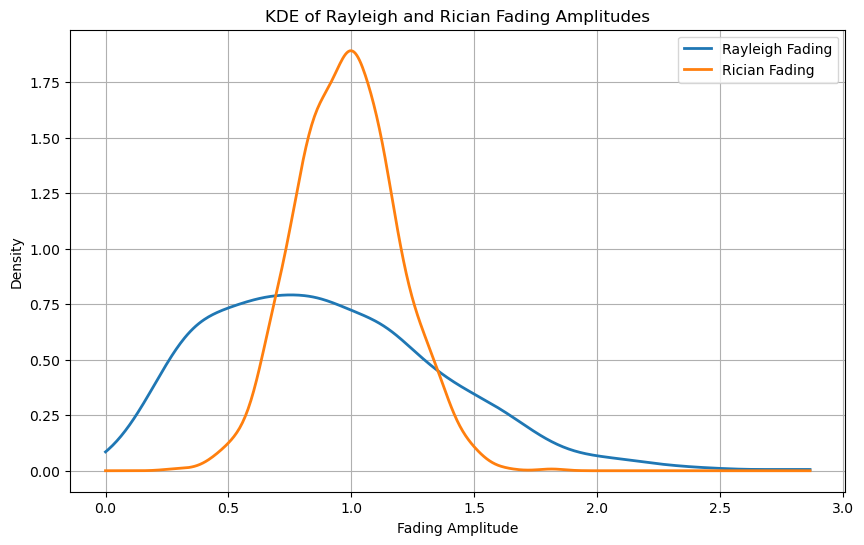

In [166]:
from scipy.stats import gaussian_kde

rician_fading_values = np.abs(rician_fading(1000))
rayleigh_fading_values = np.abs(rayleigh_fading(1000))

# Create KDEs
rayleigh_kde = gaussian_kde(rayleigh_fading_values)
rician_kde = gaussian_kde(rician_fading_values)

# Create x-axis values for plotting the smooth curves
x = np.linspace(0, max(np.max(rayleigh_fading_values), np.max(rician_fading_values)), 500)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, rayleigh_kde(x), label='Rayleigh Fading', linewidth=2)
plt.plot(x, rician_kde(x), label='Rician Fading', linewidth=2)
plt.xlabel('Fading Amplitude')
plt.ylabel('Density')
plt.title('KDE of Rayleigh and Rician Fading Amplitudes')
plt.legend()
plt.grid(True)
plt.show()


The above graph shows that Rician fading has less variance with peak at 1 while rayleigh fading has more variance but its peak is at less amplitude (0.6 approx). So this shows that with rician fading we will get more number of observations with high amplitude than with Rayleigh fading.

In [167]:

### We checkout the difference between the rician and raleigh fading values
avg_rician = np.mean(rician_fading_values)
avg_rayleigh = np.mean(rayleigh_fading_values)

print(f"Average Rician Fading: {avg_rician}")
print(f"Average Rayleigh Fading: {avg_rayleigh}")


Average Rician Fading: 0.9815009581220142
Average Rayleigh Fading: 0.8902384667528909


**Module 2: Initial Metrics**

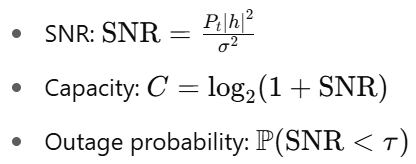

Comparison

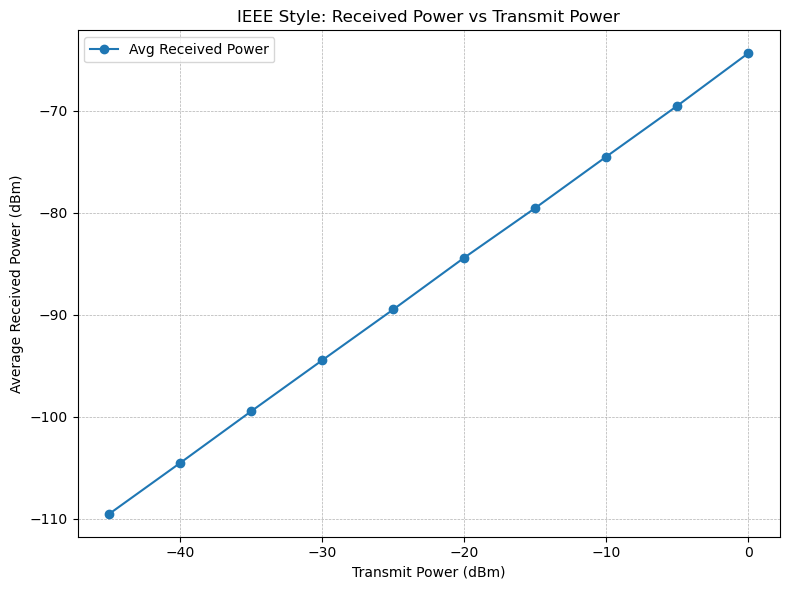

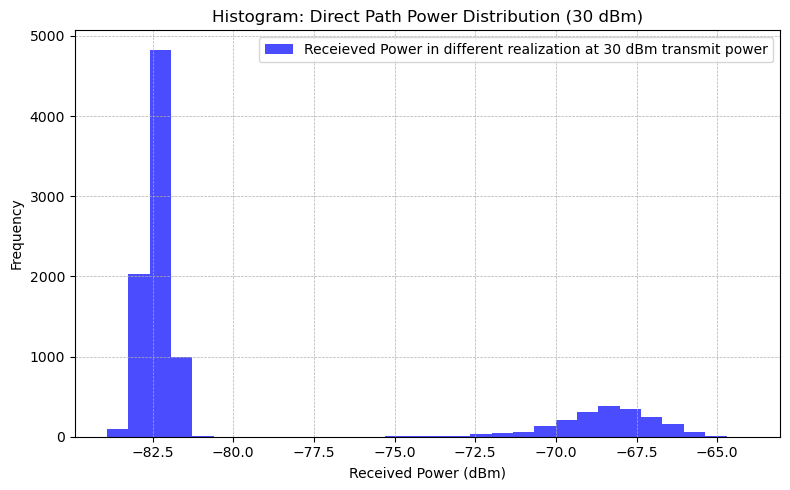

In [168]:

# === Arrays to Store Results ===
avg_pr = []

# Save realization list for one pt
pr_list_for_30_dBm_pt = []

# === Power Computation over Pt_dBm Range ===
for Pt in Pt_values:
    pr_list = []

    for _ in range(num_realizations):
        h_bs_ris , h_ris_user = random_ris_path_channel_coefficents(BS_pos, RIS_pos, User_pos, num_RIS_elements)
        h_direct = random_direct_path_channel_coefficient(BS_pos, User_pos)

        h_eff = h_direct + np.sum(h_bs_ris * h_ris_user)

        pr = received_power(Pt, h_eff)

        pr_list.append(pr)

    if Pt == Pt_values[-3]:  # Choose any Pt index (e.g., 30 dBm)
        pr_list_for_30_dBm_pt = pr_list.copy()  # Save the list for 30 dBm


    avg_pr.append(np.mean(pr_list))

# === Line Plot ===
plt.figure(figsize=(8, 6))
plt.plot(Pt_dBm_values, 10 * safe_log10(avg_pr) + 30, label='Avg Received Power', marker='o')
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Average Received Power (dBm)")
plt.title("IEEE Style: Received Power vs Transmit Power")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === Histogram Plots for Power Distribution at 30 dBm ===
plt.figure(figsize=(8, 5))
plt.hist(10 * np.log10(pr_list_for_30_dBm_pt)+30, bins=30, alpha=0.7, label='Receieved Power in different realization at 30 dBm transmit power', color='blue')
plt.xlabel("Received Power (dBm)")
plt.ylabel("Frequency")
plt.title("Histogram: Direct Path Power Distribution (30 dBm)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

SNR


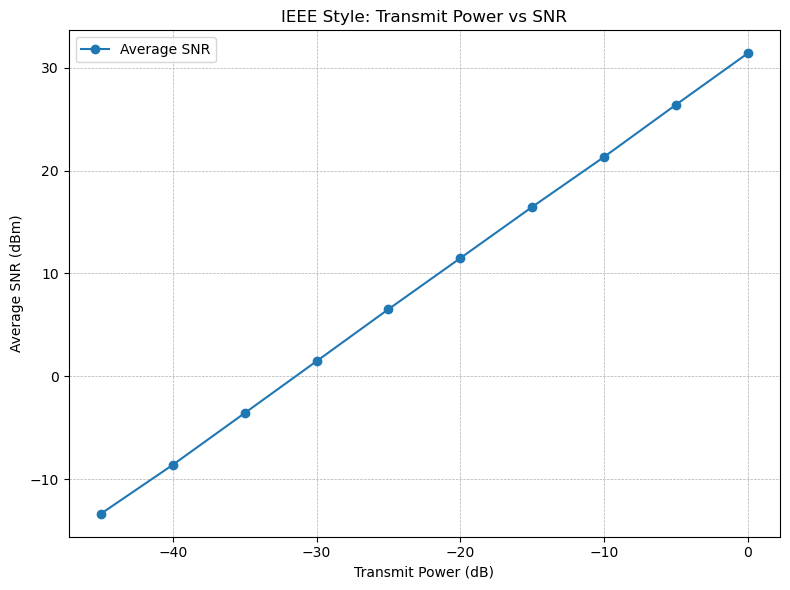

In [169]:
# === Arrays to Store SNR Results ===
avg_snr_list = []

# === Compute SNR for each Transmit Power level ===
for Pt in Pt_values:
    snr_samples = []

    for _ in range(num_realizations):
        h_bs_ris , h_ris_user = random_ris_path_channel_coefficents(BS_pos, RIS_pos, User_pos, num_RIS_elements)
        h_direct = random_direct_path_channel_coefficient(BS_pos, User_pos)

        h_eff = h_direct + np.sum(h_bs_ris * h_ris_user)

        pr = received_power(Pt, h_eff)

        snr = snr_calc(pr)
        snr_samples.append(snr)

    avg_snr_list.append(np.mean(snr_samples))

# === Plotting SNR ===
plt.figure(figsize=(8, 6))
plt.plot(Pt_dBm_values, 10 * np.log10(avg_snr_list), marker='o', label='Average SNR')
plt.xlabel("Transmit Power (dB)")
plt.ylabel("Average SNR (dBm)")
plt.title("IEEE Style: Transmit Power vs SNR")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Rate

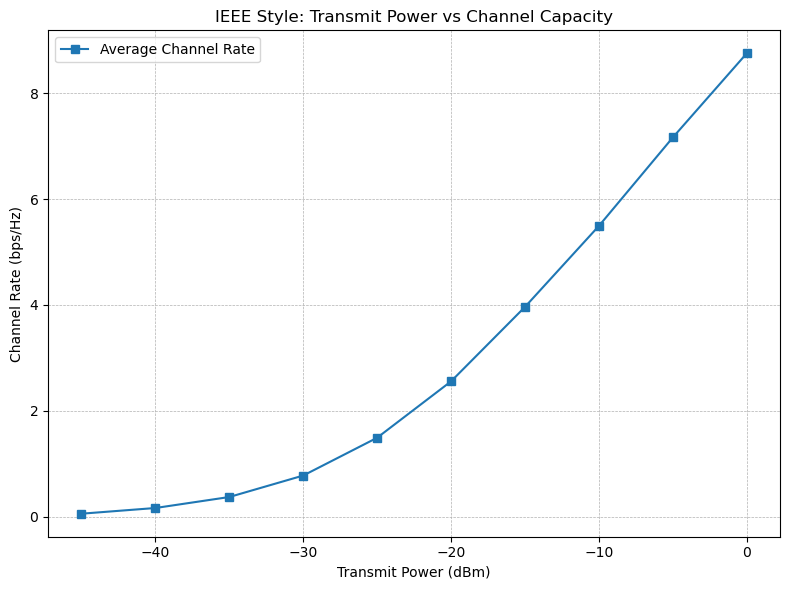

In [170]:
# === Arrays to Store Rate Results ===
avg_rate_list = []

# === Compute Channel Rate for each Transmit Power level ===
for Pt in Pt_values:
    rate_samples = []

    for _ in range(num_realizations):
        h_bs_ris , h_ris_user = random_ris_path_channel_coefficents(BS_pos, RIS_pos, User_pos, num_RIS_elements)
        h_direct = random_direct_path_channel_coefficient(BS_pos, User_pos)

        h_eff = h_direct + np.sum(h_bs_ris * h_ris_user)

        pr = received_power(Pt, h_eff)

        snr = snr_calc(pr)
        rate = np.log2(1 + snr)
        rate_samples.append(rate)

    avg_rate_list.append(np.mean(rate_samples))

# === Plotting Rate ===
plt.figure(figsize=(8, 6))
plt.plot(Pt_dBm_values, avg_rate_list, marker='s', label='Average Channel Rate')
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Channel Rate (bps/Hz)")
plt.title("IEEE Style: Transmit Power vs Channel Capacity")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Outage Probability

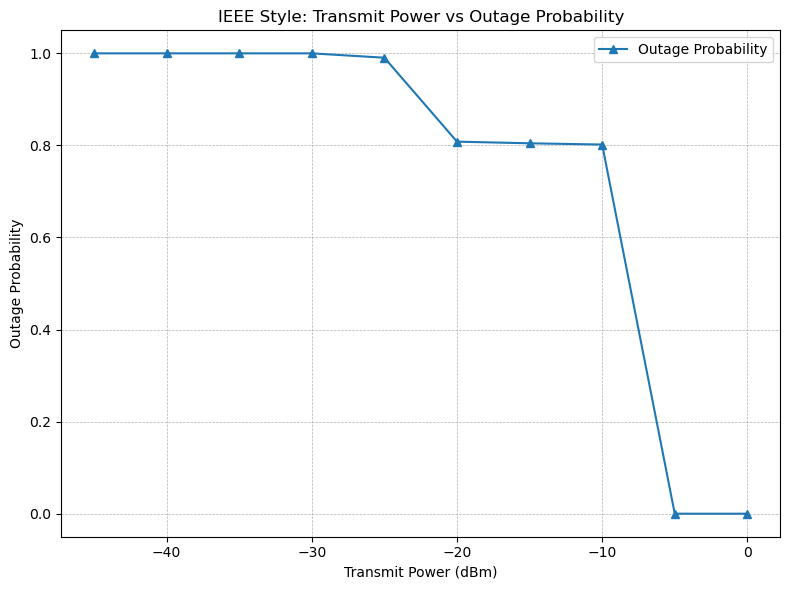

In [171]:
# === Outage Threshold ===
tau = 5  # bps/Hz outage threshold

# === Arrays to Store Outage Probability Results ===
outage_probs = []

# === Compute Outage Probability for each Transmit Power level ===
for Pt in Pt_values:
    outage_count = 0

    for _ in range(num_realizations):
        h_bs_ris , h_ris_user = random_ris_path_channel_coefficents(BS_pos, RIS_pos, User_pos, num_RIS_elements)
        h_direct =  random_direct_path_channel_coefficient(BS_pos, User_pos)

        h_eff = h_direct + np.sum(h_bs_ris * h_ris_user)

        pr = received_power(Pt, h_eff)

        snr = snr_calc(pr)
        rate = np.log2(1 + snr)

        if rate < tau:
            outage_count += 1

    outage_prob = outage_count / num_realizations
    outage_probs.append(outage_prob)

# === Plotting Outage Probability ===
plt.figure(figsize=(8, 6))
plt.plot(Pt_dBm_values, outage_probs, marker='^', label='Outage Probability')
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("IEEE Style: Transmit Power vs Outage Probability")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Change of Number of Realisations and RIS elements

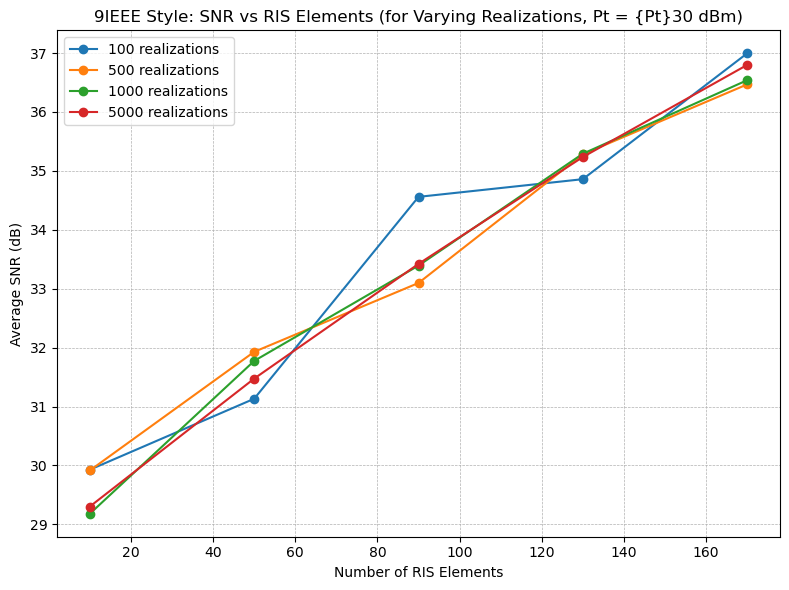

In [172]:
# === RIS and Realizations Parameters ===
RIS_elements_range = np.arange(10, 201, 40)
num_realizations_list = [100, 500, 1000, 5000]

fixed_Pt_dBm = 30
fixed_Pt = 10 ** ((fixed_Pt_dBm - 30) / 10) 

# === Store all results in matrix: rows = realizations, cols = RIS elements ===
results_matrix = np.zeros((len(num_realizations_list), len(RIS_elements_range)))

# === Main Simulation Loop ===
for i, n_real in enumerate(num_realizations_list):
    for j, N_RIS in enumerate(RIS_elements_range):
        snr_samples = []
        for _ in range(n_real):

            h_bs_ris , h_ris_user = random_ris_path_channel_coefficents(BS_pos, RIS_pos, User_pos, N_RIS)
            h_direct = random_direct_path_channel_coefficient(BS_pos, User_pos)

            h_eff = h_direct + np.sum(h_bs_ris * h_ris_user)

            pr = received_power(Pt, h_eff)
            
            snr = snr_calc(pr)
            snr_samples.append(snr)
        results_matrix[i, j] = 10 * np.log10(np.mean(snr_samples))  # Store in dBm

# === Plotting ===
plt.figure(figsize=(8, 6))
for i, n_real in enumerate(num_realizations_list):
    plt.plot(RIS_elements_range, results_matrix[i], marker='o', label=f'{n_real} realizations')

plt.xlabel("Number of RIS Elements")
plt.ylabel("Average SNR (dB)")
plt.title("9IEEE Style: SNR vs RIS Elements (for Varying Realizations, Pt = {Pt}30 dBm)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Our observation shows that increasing RIS elements over greater number of channel realisations gives increasing trend for the SNR calculated, which is in exact correspondence to our expectations.

Assuming Optimised RIS

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
wavelength = 0.1  # 3 GHz signal (~0.1 m)
K_rician = 10
Pt = 10  # Transmit power (W)
N0 = 1e-3  # Noise power (W)
RIS_elements = np.arange(10, 1100, 100)
num_samples = 10000

# Distances
d_bs_ris = 50
d_ris_rx = 50
d_direct = 100


# === Core Functions ===

# def path_loss(d):
#     return (d**(-n))
# Path loss model
def path_loss(d, wavelength=wavelength):
    return (wavelength / (4 * np.pi * d)) ** 2

# # Rayleigh fading for direct path
def rayleigh_fading(scale, size):
    return np.sqrt(scale) * (np.random.normal(0, np.sqrt(0.5), size) +
                             1j * np.random.normal(0, np.sqrt(0.5), size))

# # Rician fading for RIS components
def rician_fading(N, K, samples):
    LOS = np.ones((samples, N))
    NLOS = np.sqrt(0.5) * (np.random.randn(samples, N) + 1j * np.random.randn(samples, N))
    return np.sqrt(K / (K + 1)) * LOS + np.sqrt(1 / (K + 1)) * NLOS


def snr_calc(Pr):
    return Pr / N

def outage_probability(rate, tau):
    return np.mean(rate < tau)

def received_power(Pt, h):
    return Pt * (h ** 2)

def random_ris_path_channel_coefficents(N_elements, samples=num_samples):
 
    fading_bs_ris = rician_fading(N_elements, K_rician, samples)
    fading_ris_user = rician_fading(N_elements, K_rician, samples)

    h_bs_ris = np.sqrt(path_loss(d_bs_ris)) * fading_bs_ris
    h_ris_user = np.sqrt(path_loss(d_ris_rx)) * fading_ris_user

    return np.abs(h_bs_ris), np.abs(h_ris_user)
                                                                                ###   Assumption ####


# Direct channel gain magnitude
def direct_channel_gain(samples=num_samples):
    return np.abs(rayleigh_fading(scale=path_loss(d_direct), size=samples))


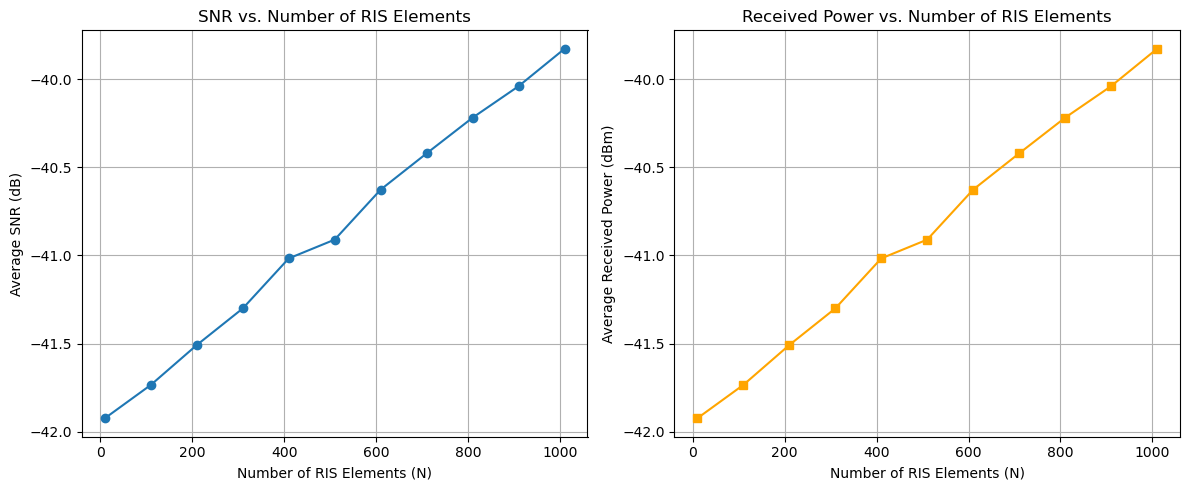

In [174]:


# Collect average SNR and received power
avg_snr_db = []
avg_power_dbm = []

for N in RIS_elements:

    # h_ris = ris_channel_gain_coherent(N)
    h_bs_ris , h_ris_user = random_ris_path_channel_coefficents(N)
    h_direct = direct_channel_gain()

    h_eff = h_direct + np.sum(h_bs_ris * h_ris_user, axis=1)
    # h_eff = h_direct + h_ris

    pr = Pt * (h_eff ** 2)
    # pr = received_power(Pt, h_eff)
    

    snr = pr / N0

    avg_snr_db.append(10 * np.log10(np.mean(snr)))
    avg_power_dbm.append(10 * np.log10(np.mean(pr)) + 30)  # dBm

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(RIS_elements, avg_snr_db, marker='o')
plt.title("SNR vs. Number of RIS Elements")
plt.xlabel("Number of RIS Elements (N)")
plt.ylabel("Average SNR (dB)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(RIS_elements, avg_power_dbm, marker='s', color='orange')
plt.title("Received Power vs. Number of RIS Elements")
plt.xlabel("Number of RIS Elements (N)")
plt.ylabel("Average Received Power (dBm)")
plt.grid(True)

plt.tight_layout()
plt.show()
